In [1]:
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tqdm import trange
from itertools import combinations
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Reshape, Lambda, Input, LeakyReLU
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

In [2]:
img_dim=512

In [3]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = train_datagen.flow_from_directory(
    directory=r"../input/airbnb-duplicate-image-detection/Airbnb Data/Training Data",
    color_mode="rgb",
    batch_size=1,
    target_size=(img_dim, img_dim),
    class_mode="sparse",
    shuffle=False,
    seed=42
)

Found 631 images belonging to 12 classes.


In [4]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(
    directory=r"../input/airbnb-duplicate-image-detection/Airbnb Data/Test Data",
    color_mode="rgb",
    batch_size=1,
    target_size=(img_dim, img_dim),
    class_mode="sparse",
    shuffle=False,
    seed=42
)

Found 233 images belonging to 5 classes.


In [5]:
# https://jkjung-avt.github.io/keras-image-cropping/

def random_crop(img, random_crop_size=(img_dim, img_dim)):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]

def crop(batch):
    batch_crops = np.zeros((batch.shape[0], img_dim, img_dim, 3))
    for i in range(batch.shape[0]):
        batch_crops[i] = random_crop(batch[i])
    return batch_crops

def crop_generator(batches):
    """Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator.
    """
    while True:
        tup = next(batches)
        yield (crop(tup[0]), crop(tup[1]), *tup[2:])

In [6]:
# id_dict = (id, cls) -> [positive examples]
# class_dict = (id) -> {cls}

def get_dicts(image_generator):
  id_dict = {}
  class_dict = {}
  for idx in trange(len(image_generator)):
    img, cls = image_generator.next()
    img_name = image_generator.filenames[idx]
    img = img[0]
    cls = int(cls[0])
    id = img_name.split('_')[1]
    if id in class_dict:
      class_dict[id].add(cls)
    else:
      class_dict[id] = {cls}
    if (id, cls) in id_dict:
      id_dict[(id, cls)].append(img)
    else:
      id_dict[(id, cls)] = [img]
  return id_dict, class_dict

In [7]:
train_id_dict, train_class_dict = get_dicts(train_generator)
test_id_dict, test_class_dict = get_dicts(test_generator)

100%|██████████| 233/233 [00:05<00:00, 44.52it/s]


In [8]:
!nvidia-smi

Fri Dec 20 21:13:41 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [9]:
# returns a tuple of (batch_a, batch_b, epoch_end)
#                    (Tensor, Tensor, bool) where bool indicates end of epoch

def get_pos_batch(class_dict, id_dict, batch_size = 32):
  batch_a =  np.zeros((batch_size, img_dim, img_dim, 3)) # (16, 256, 256, 3)
  batch_b =  np.zeros((batch_size, img_dim, img_dim, 3)) # (16, 256, 256, 3)
  batch_idx = 0
  class_keys = list(class_dict.keys())
  np.random.shuffle(class_keys)
  for id in class_keys:
    classes = class_dict[id]
    for cls in classes:
      pos_examples = id_dict[(id,cls)] # list of positive examples
      for a, b in combinations(pos_examples, 2):
        batch_a[batch_idx, :, :, :] = a
        batch_b[batch_idx, :, :, :] = b
        batch_idx += 1
        if batch_idx == batch_size:
          yield [batch_a[:batch_idx], batch_b[:batch_idx], False]
          batch_a =  np.zeros((batch_size, img_dim, img_dim, 3))
          batch_b =  np.zeros((batch_size, img_dim, img_dim, 3))
          batch_idx = 0
  yield [batch_a[:batch_idx], batch_b[:batch_idx], True]

In [10]:
def get_neg_batch(class_dict, id_dict, batch_size = 32):
  batch_a =  np.zeros((batch_size, img_dim, img_dim, 3)) # (16, 256, 256, 3)
  batch_b =  np.zeros((batch_size, img_dim, img_dim, 3)) # (16, 256, 256, 3)
  batch_idx = 0
  ids = list(class_dict.keys())

  while True:
    random_ids = np.random.choice(ids, 2)
    classes_for_id_one = list(class_dict[random_ids[0]])
    random_class_from_one = np.random.choice(classes_for_id_one ,1)[0]
    classes_for_id_two = list(class_dict[random_ids[1]])
    random_class_from_two = np.random.choice(classes_for_id_two ,1)[0]

    if random_class_from_two != random_class_from_one:
      a, b = id_dict[(random_ids[0],random_class_from_one)], id_dict[(random_ids[1],random_class_from_two)]
      batch_a[batch_idx, :, :, :] = a[np.random.choice(len(a))]
      batch_b[batch_idx, :, :, :] = b[np.random.choice(len(b))]
      batch_idx += 1
      if batch_idx == batch_size:
        yield [batch_a[:batch_idx], batch_b[:batch_idx]]
        batch_a =  np.zeros((batch_size, img_dim, img_dim, 3))
        batch_b =  np.zeros((batch_size, img_dim, img_dim, 3))
        batch_idx = 0 

In [11]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

In [12]:
optimizer = Adam()
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_dim, img_dim, 3))
base_model.trainable=False
model = Sequential([
       base_model,   
       Conv2D(filters=1, kernel_size=(1,1)),
       Reshape((256,)),
       Dense(32, activation=LeakyReLU(0.1)),
       Dense(16)
])

model.summary()

94773248/94765736 [==============================] - 88s 1us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 16, 16, 2048)      23587712  
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 1)         2049      
_________________________________________________________________
reshape (Reshape)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                8224      
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
Total params: 23,598,513
Trainable params: 10,801
Non-trainable params: 23,587,712
_________________________________________________________________


In [13]:
inp_a = Input(shape=(img_dim, img_dim, 3), name='a') 
inp_b = Input(shape=(img_dim, img_dim, 3), name='b') 
out_a, out_b = model(inp_a), model(inp_b)
distance = Lambda(euclidean_distance, 
                  output_shape=eucl_dist_output_shape) ([out_a, out_b])

final_model = Model([inp_a, inp_b], distance)
final_model.compile(optimizer=optimizer, loss=contrastive_loss)
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
a (InputLayer)                  [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
b (InputLayer)                  [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 16)           23598513    a[0][0]                          
                                                                 b[0][0]                          
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           sequential[1][0]             

In [14]:
epochs, k = 20, 5

In [15]:
pos_loss = []
neg_loss = []
for epoch in trange(epochs):
  pos_gen = crop_generator(get_pos_batch(train_class_dict, train_id_dict, 32))
  neg_gen = crop_generator(get_neg_batch(train_class_dict, train_id_dict, 32))
  ###### 1 epoch ####################################
  p_loss, p_batches = 0, 0
  n_loss, n_batches = 0, 0
  while True:
    # positive examples
    batch_a, batch_b, epoch_end = next(pos_gen)
    pos_y = np.ones((batch_a.shape[0], 1))
    loss = final_model.train_on_batch({'a' : batch_a, 'b' : batch_b}, pos_y)
    p_loss += loss
    p_batches += 1

    # negative examples
    for _ in range(k):
      batch_a, batch_b = next(neg_gen)
      neg_y = np.zeros((batch_a.shape[0], 1))
      loss = final_model.train_on_batch({'a' : batch_a, 'b' : batch_b}, neg_y)
      n_loss += loss
      n_batches += 1

    if epoch_end:
      p_loss = p_loss / p_batches
      n_loss = n_loss / n_batches
      break
  ###### 1 epoch ####################################
  print(f'Epoch: {epoch+1}, time: {datetime.now().strftime("%H:%M:%S")}')
  print(f'avg (+) contrastive loss: {p_loss}')
  print(f'avg (-) contrastive loss: {n_loss}')
  pos_loss.append(p_loss)
  neg_loss.append(n_loss)

  5%|▌         | 1/20 [02:32<48:24, 152.88s/it]

Epoch: 1, time: 21:17:55
avg (+) contrastive loss: 47.84017066955566
avg (-) contrastive loss: 0.0002322820504390203


 10%|█         | 2/20 [04:51<44:36, 148.68s/it]

Epoch: 2, time: 21:20:13
avg (+) contrastive loss: 1.8382357120513917
avg (-) contrastive loss: 0.0019424628817000667


 15%|█▌        | 3/20 [07:10<41:18, 145.80s/it]

Epoch: 3, time: 21:22:32
avg (+) contrastive loss: 1.4050607840220133
avg (-) contrastive loss: 0.005109347785522308


 20%|██        | 4/20 [09:30<38:21, 143.82s/it]

Epoch: 4, time: 21:24:52
avg (+) contrastive loss: 1.2152512232462565
avg (-) contrastive loss: 0.007396148525488874


 25%|██▌       | 5/20 [11:49<35:36, 142.41s/it]

Epoch: 5, time: 21:27:11
avg (+) contrastive loss: 1.0707592527071634
avg (-) contrastive loss: 0.011341398448372881


 30%|███       | 6/20 [14:08<33:00, 141.45s/it]

Epoch: 6, time: 21:29:30
avg (+) contrastive loss: 0.9843903740247091
avg (-) contrastive loss: 0.013773801165322463


 35%|███▌      | 7/20 [16:27<30:30, 140.81s/it]

Epoch: 7, time: 21:31:49
avg (+) contrastive loss: 0.8924232204755147
avg (-) contrastive loss: 0.018421819272140663


 40%|████      | 8/20 [18:47<28:06, 140.51s/it]

Epoch: 8, time: 21:34:09
avg (+) contrastive loss: 0.8036610205968221
avg (-) contrastive loss: 0.022507665703694026


 45%|████▌     | 9/20 [21:06<25:41, 140.16s/it]

Epoch: 9, time: 21:36:28
avg (+) contrastive loss: 0.7526935895284017
avg (-) contrastive loss: 0.0256792493040363


 50%|█████     | 10/20 [23:26<23:21, 140.16s/it]

Epoch: 10, time: 21:38:49
avg (+) contrastive loss: 0.7085605065027872
avg (-) contrastive loss: 0.025491481237113475


 55%|█████▌    | 11/20 [25:46<21:01, 140.11s/it]

Epoch: 11, time: 21:41:09
avg (+) contrastive loss: 0.6748944560686747
avg (-) contrastive loss: 0.027463747014602025


 60%|██████    | 12/20 [28:07<18:40, 140.10s/it]

Epoch: 12, time: 21:43:29
avg (+) contrastive loss: 0.6320130109786988
avg (-) contrastive loss: 0.028298665881156922


 65%|██████▌   | 13/20 [30:26<16:19, 139.98s/it]

Epoch: 13, time: 21:45:48
avg (+) contrastive loss: 0.6344547271728516
avg (-) contrastive loss: 0.02771230095376571


 70%|███████   | 14/20 [32:46<13:59, 139.97s/it]

Epoch: 14, time: 21:48:08
avg (+) contrastive loss: 0.5916488448778788
avg (-) contrastive loss: 0.02780989712725083


 75%|███████▌  | 15/20 [35:06<11:40, 140.02s/it]

Epoch: 15, time: 21:50:28
avg (+) contrastive loss: 0.5594307084878286
avg (-) contrastive loss: 0.02684321653097868


 80%|████████  | 16/20 [37:26<09:19, 139.97s/it]

Epoch: 16, time: 21:52:48
avg (+) contrastive loss: 0.5605570912361145
avg (-) contrastive loss: 0.03017195695390304


 85%|████████▌ | 17/20 [39:46<06:59, 139.98s/it]

Epoch: 17, time: 21:55:08
avg (+) contrastive loss: 0.5439019540945689
avg (-) contrastive loss: 0.026361467813452086


 90%|█████████ | 18/20 [42:06<04:39, 139.91s/it]

Epoch: 18, time: 21:57:28
avg (+) contrastive loss: 0.5261201500892639
avg (-) contrastive loss: 0.027578319398065407


 95%|█████████▌| 19/20 [44:26<02:19, 139.98s/it]

Epoch: 19, time: 21:59:48
avg (+) contrastive loss: 0.4911152044932047
avg (-) contrastive loss: 0.02673828635364771


100%|██████████| 20/20 [46:46<00:00, 140.33s/it]

Epoch: 20, time: 22:02:08
avg (+) contrastive loss: 0.49415417909622195
avg (-) contrastive loss: 0.025990015771239997


In [16]:
# Get some positive examples and negative examples (TRAIN)
pos_gen = crop_generator(get_pos_batch(train_class_dict, train_id_dict))
neg_gen = crop_generator(get_neg_batch(train_class_dict, train_id_dict))

X_distance= []
y_distance = []

pos_batch_count = 0
neg_to_pos_ratio = 1

while True:
  batch_a, batch_b, epoch_end = next(pos_gen)
  for x in final_model.predict([batch_a, batch_b]):
    X_distance.append(x)
  y_distance += [1] * len(batch_a)
  pos_batch_count += 1
  if epoch_end:
    break

for _ in range(pos_batch_count * neg_to_pos_ratio):
  batch_a, batch_b = next(neg_gen)
  for x in final_model.predict([batch_a, batch_b]):
    X_distance.append(x)
  y_distance += [0] * len(batch_a)

X_distance, y_distance = np.array(X_distance).reshape((-1,)), np.array(y_distance)
X_distance = X_distance.reshape((-1, 1))

print(X_distance.shape, y_distance.shape)

(944, 1) (944,)


In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

clf = LogisticRegression(random_state=0, solver='lbfgs').fit(X_distance, y_distance)

print('Training F1 Score:', f1_score(y_distance, clf.predict(X_distance)))

Training F1 Score: 0.6986721144024514


[47.84017066955566, 1.8382357120513917, 1.4050607840220133, 1.2152512232462565, 1.0707592527071634, 0.9843903740247091, 0.8924232204755147, 0.8036610205968221, 0.7526935895284017, 0.7085605065027872, 0.6748944560686747, 0.6320130109786988, 0.6344547271728516, 0.5916488448778788, 0.5594307084878286, 0.5605570912361145, 0.5439019540945689, 0.5261201500892639, 0.4911152044932047, 0.49415417909622195]


<function matplotlib.pyplot.show(*args, **kw)>

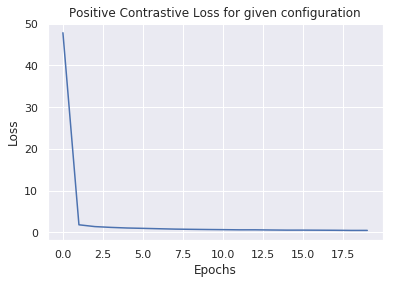

In [18]:
print(pos_loss)
plt.plot(np.arange(epochs), pos_loss)
plt.title('Positive Contrastive Loss for given configuration')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show

[0.0002322820504390203, 0.0019424628817000667, 0.005109347785522308, 0.007396148525488874, 0.011341398448372881, 0.013773801165322463, 0.018421819272140663, 0.022507665703694026, 0.0256792493040363, 0.025491481237113475, 0.027463747014602025, 0.028298665881156922, 0.02771230095376571, 0.02780989712725083, 0.02684321653097868, 0.03017195695390304, 0.026361467813452086, 0.027578319398065407, 0.02673828635364771, 0.025990015771239997]


<function matplotlib.pyplot.show(*args, **kw)>

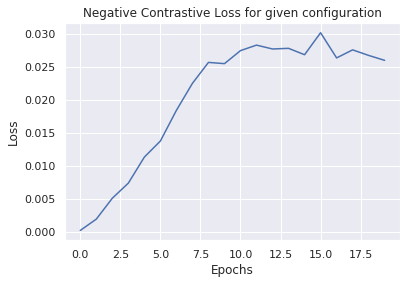

In [19]:
print(neg_loss)
plt.plot(np.arange(epochs), neg_loss)
plt.title('Negative Contrastive Loss for given configuration')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show

In [20]:
#TESTING
# Get some positive examples and negative examples (TRAIN)
pos_gen = crop_generator(get_pos_batch(test_class_dict, test_id_dict))
neg_gen = crop_generator(get_neg_batch(test_class_dict, test_id_dict))

X_distance= []
y_distance = []

pos_batch_count = 0
neg_to_pos_ratio = 1 # DONT CHANGE THIS

while True:
  batch_a, batch_b, epoch_end = next(pos_gen)
  for x in final_model.predict([batch_a, batch_b]):
    X_distance.append(x)
  y_distance += [1] * len(batch_a)
  pos_batch_count += 1
  if epoch_end:
    break

for _ in range(pos_batch_count * neg_to_pos_ratio):
  batch_a, batch_b = next(neg_gen)
  for x in final_model.predict([batch_a, batch_b]):
    X_distance.append(x)
  y_distance += [0] * len(batch_a)

X_distance, y_distance = np.array(X_distance).reshape((-1,)), np.array(y_distance)
X_distance = X_distance.reshape((-1, 1))

print(X_distance.shape, y_distance.shape)

(294, 1) (294,)


In [21]:
print('Testing F1 Score:', f1_score(y_distance, clf.predict(X_distance)))

Testing F1 Score: 0.6195286195286195
